In [1]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import os
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from preprocessors import OutlierRemover, AgeAssigner, MetadataAvgTransformer, CountryAssigner
from data_plotter import DataPlotter

/Users/denis/Desktop/unabomber/computational_DS/CDS_Final_Project/src/preprocessors/__init__.py:12: DtypeWarning: Columns (22,36,39,42,43,52,55,58,61,72,73,75,115,123,126,127) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metadata_path)


In [2]:
CWD = os.path.abspath("")

In [3]:
data_path = Path(CWD).parent / "data/car_prices.csv"
maetadata_path = Path(CWD).parent / "data/Safercar_data.csv"

In [4]:
data = pd.read_csv(data_path).drop(columns=["Unnamed: 0"])
metadata = pd.read_csv(maetadata_path)

/var/folders/_k/4jmlcdh94fn8f_g2j15scs2m0000gn/T/ipykernel_39686/3166012254.py:2: DtypeWarning: Columns (22,36,39,42,43,52,55,58,61,72,73,75,115,123,126,127) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(maetadata_path)


# EDA

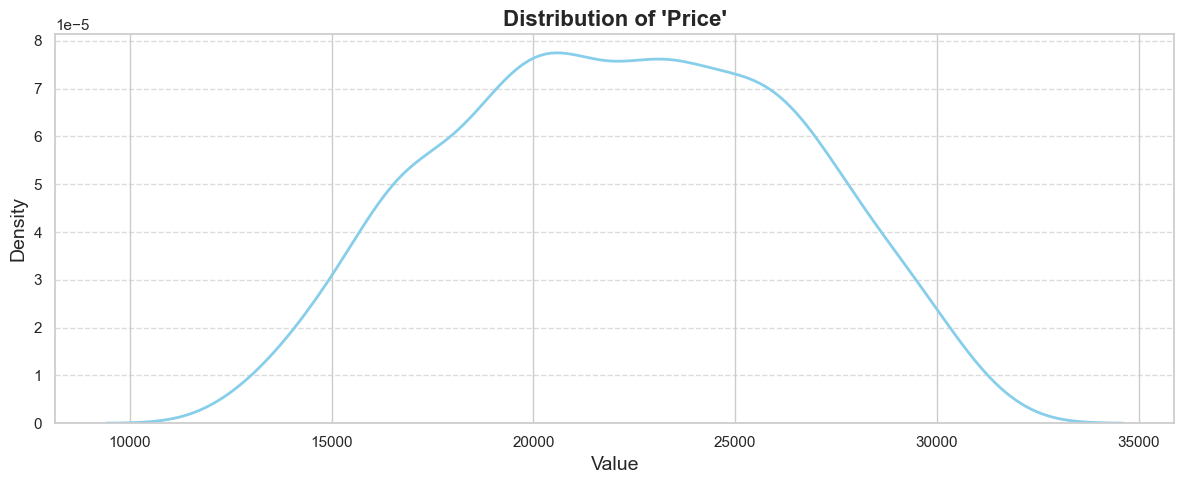

In [5]:
plotter = DataPlotter()

plotter.plot_numerical_distribution(data, ["Price"])

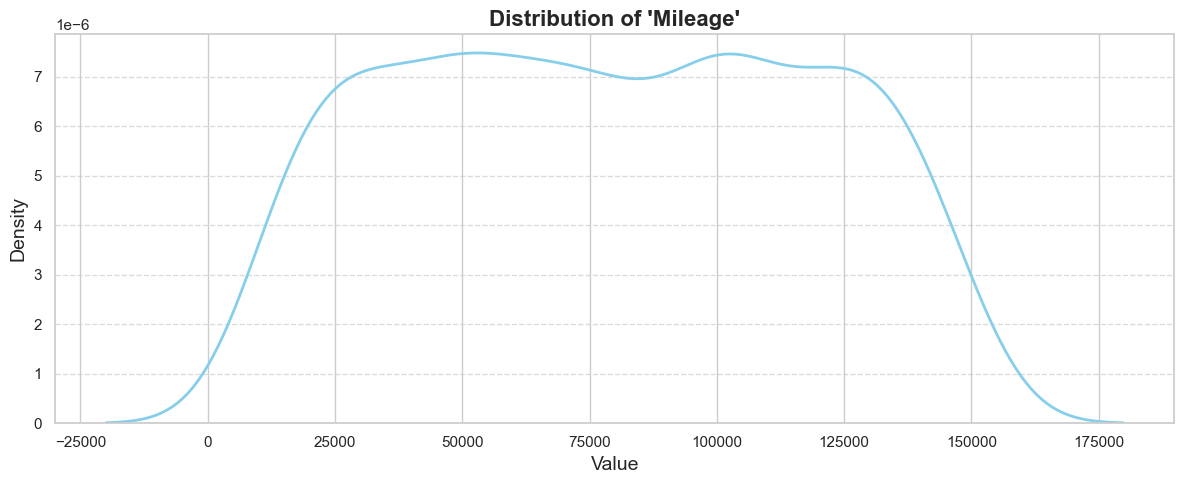

In [6]:
plotter.plot_numerical_distribution(data, ["Mileage"])

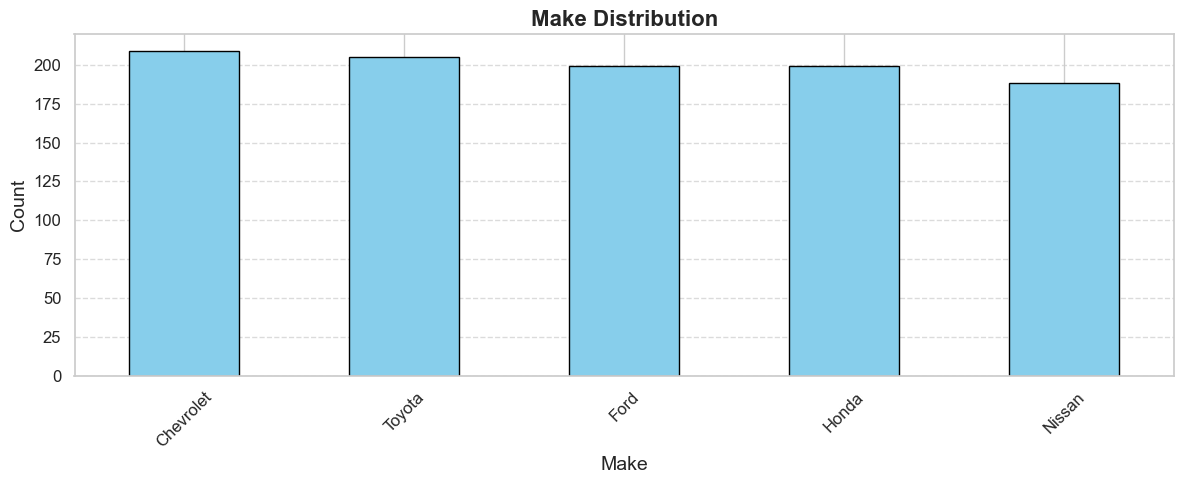

In [7]:
plotter.plot_all_categorical(data[["Make"]])

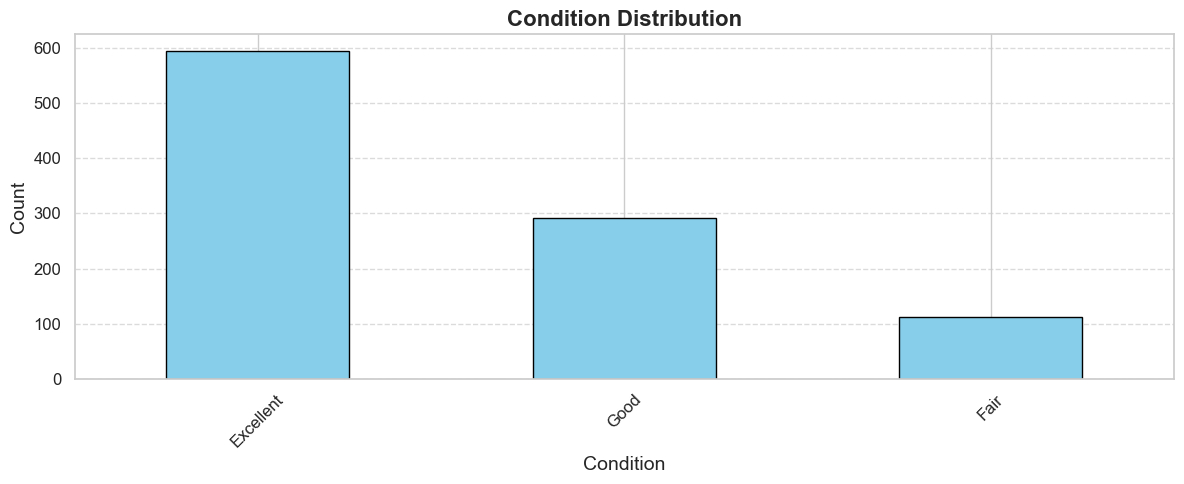

In [8]:
plotter.plot_all_categorical(data[["Condition"]])

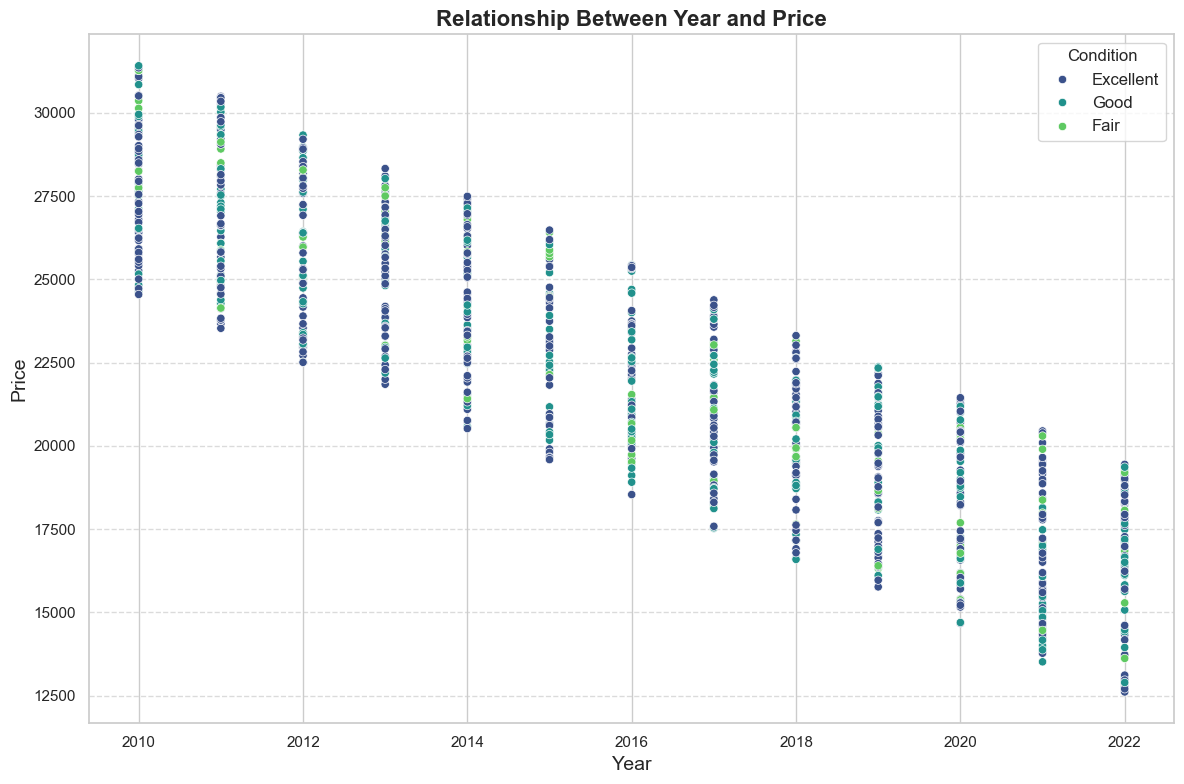

In [9]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x="Year", y="Price", hue="Condition", palette="viridis")
plt.title("Relationship Between Year and Price", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Condition", fontsize=12)
plt.tight_layout()
plt.show()

# Splitting and OHE

In [10]:
X = data.drop(columns=["Price", "Model"])
y = data["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_features = ["Condition", "Country", "Make"]
num_features = ["Mileage", "OVERALL_STARS", "CURB_WEIGHT", "MIN_GROSS_WEIGHT", "Age"]

preprocessing = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(handle_unknown='ignore'), cat_features),
        ("num", "passthrough", num_features)
    ]
)

In [11]:
pipeline = Pipeline([
    ("metadata_avg", MetadataAvgTransformer(columns=["OVERALL_STARS", "CURB_WEIGHT", "MIN_GROSS_WEIGHT"])),
    ("country", CountryAssigner()),
    ("age", AgeAssigner()),
    ("outlier_remover", OutlierRemover(column="Mileage", threshold=3)),
    ("preprocessing", preprocessing),
    ("regressor", DecisionTreeRegressor(random_state=42))
])

# Hyperparameters tuning

/Users/denis/Desktop/unabomber/computational_DS/CDS_Final_Project/src/preprocessors/__init__.py:12: DtypeWarning: Columns (22,36,39,42,43,52,55,58,61,72,73,75,115,123,126,127) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metadata_path)
/Users/denis/Desktop/unabomber/computational_DS/CDS_Final_Project/src/preprocessors/__init__.py:12: DtypeWarning: Columns (22,36,39,42,43,52,55,58,61,72,73,75,115,123,126,127) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metadata_path)
/Users/denis/Desktop/unabomber/computational_DS/CDS_Final_Project/src/preprocessors/__init__.py:12: DtypeWarning: Columns (22,36,39,42,43,52,55,58,61,72,73,75,115,123,126,127) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metadata_path)
/Users/denis/Desktop/unabomber/computational_DS/CDS_Final_Project/src/preprocessors/__init__.py:12: DtypeWarning: Columns (22,36,3

Best max_depth: 10
Best model saved as model.pkl
Best R-squared on test data: 0.9984


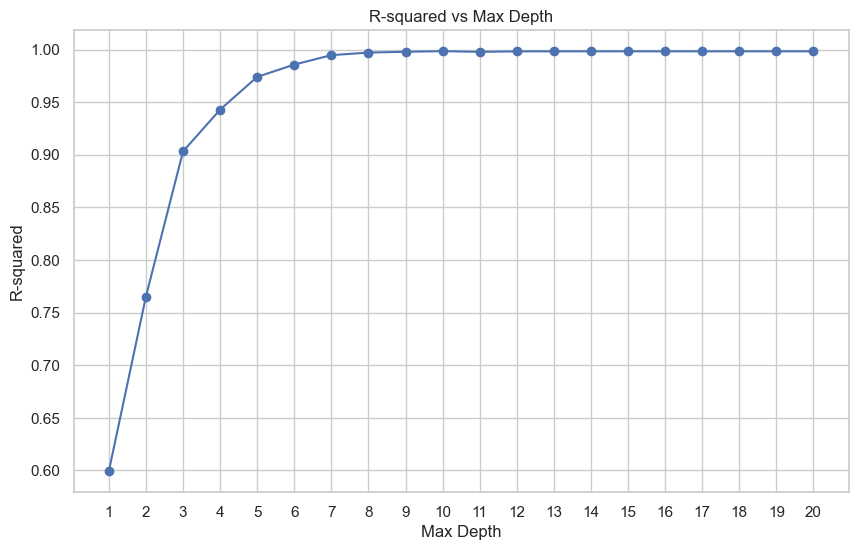

In [12]:
param_grid = {"regressor__max_depth": range(1, 21)}

grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    scoring="r2", 
    cv=5, 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_max_depth = grid_search.best_params_["regressor__max_depth"]
print(f"Best max_depth: {best_max_depth}")

best_pipeline = grid_search.best_estimator_

joblib.dump(best_pipeline, "best_model.pkl")
print("Best model saved as model.pkl")

y_pred = best_pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Best R-squared on test data: {r2:.4f}")

r2_values = []
for depth in range(1, 21):
    pipeline.set_params(regressor__max_depth=depth)
    pipeline.fit(X_train, y_train)
    y_pred_for_depth = pipeline.predict(X_test)
    r2_values.append(r2_score(y_test, y_pred_for_depth))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), r2_values, marker="o", linestyle="-", color="b")
plt.xlabel("Max Depth")
plt.ylabel("R-squared")
plt.title("R-squared vs Max Depth")
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()
